In [12]:
from os import listdir, stat
from os.path import isfile, join

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
%matplotlib inline

In [21]:
ssd_ofs = pd.read_csv('data/ssd-ofs-all.csv')
ssd_omap = pd.read_csv('data/ssd-omap-res.csv')
sizes = pd.read_csv('data/sizes.csv')

In [23]:
ssd_ofs.columns

Index(['test', 'data_mem', 'aux_mem', 'ssd', 'cached', 'bbs', 'n', 's', 'lf',
       'id', 'insert', 'insert_bytes', 'load_data', 'search', 'search_bytes',
       'search_false_pos', 'setup', 'setup_bytes', 'vl', 'total_time'],
      dtype='object')

In [30]:
import itertools


def filterr(df, col, val):
    return df[df[col] == val].reset_index(drop=True)

# ofs = filterr(raw_data, 'test', 'ofs')
# hofs = filterr(ofs, 'ssd', 0)
# sofs = filterr(ofs, 'ssd', 1)

# hnlgn = hofs[hofs['s'] == (np.log2(hofs['n'])+1)]
# hblor = hofs[hofs['s'] != (np.log2(hofs['n'])+1)]
# snlgn = sofs[sofs['s'] == (np.log2(sofs['n'])+1)]
# sblor = sofs[sofs['s'] != (np.log2(sofs['n'])+1)]


# omap = filterr(raw_data, 'test', 'omap')
# homap = filterr(omap, 'ssd', 0)
# somap = filterr(omap, 'ssd', 1)

s_list = sorted(list(set(ssd_ofs['s'])))
lf_list = sorted(list(set(ssd_ofs['lf'])))

slf_pairs = []
for lf in lf_list:
    lfofs = filterr(ssd_ofs, 'lf', lf)
    for s in s_list:
        slfofs = filterr(lfofs, 's', s)
        if len(slfofs) > 0:
            slf_pairs.append((s, lf,))

id_list = sorted(list(set(ssd_ofs['id'])))

In [41]:
size_id_pairs = []
for id in id_list:
    idofs = filterr(ssd_ofs, 'id', id)
    vls = list(set(idofs['vl']))
    num_vls = len(vls)
    if (num_vls) != 1:
        print(id, num_vls)
        break
    size_id_pairs.append((vls[0], id,))
size_id_pairs = sorted(size_id_pairs, key=lambda x: x[0])
# If nothing is printed, we're fine!
ids_sorted = [x[1] for x in size_id_pairs]

In [139]:
# data = [hnlgn, hblor, homap, snlgn, sblor, somap]
# labels = ['NlgN (HDD)', 'Ns (HDD)', 'OMap (HDD)', 'NlgN (SSD)', 'Ns (SSD)', 'OMap (SSD)']
# colors = ['b', 'g', 'r', 'b', 'g', 'r']
# markers = ['', '', '', '+', '+', '+']
# linestyles = ['-.', '-.', '-.', '-', '-', '-']

In [28]:
def plot_line(xs, ys, label, color=None, marker=None, linestyle='-', ax=None):
    if ax is None:
        ax = plt
    return ax.plot(xs, ys, label=label, color=color, marker=marker, linestyle=linestyle)


# def plot_line_s(xs, ys, i, ax=None):
#     plot_line(xs, ys, labels[i], colors[i], markers[i], linestyles[i], ax)


def setup_plot(title, xlabel, ylabel, ax=None, xscale='linear', xbase=10, yscale='linear', ybase=10):
    if ax is not None:
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if xscale != 'linear':
            ax.set_xscale(xscale, base=xbase)
        if yscale != 'linear':
            ax.set_yscale(yscale, base=ybase)
        return
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xscale != 'linear':
        plt.xscale(xscale, base=xbase)
    if yscale != 'linear':
        plt.yscale(yscale, base=ybase)

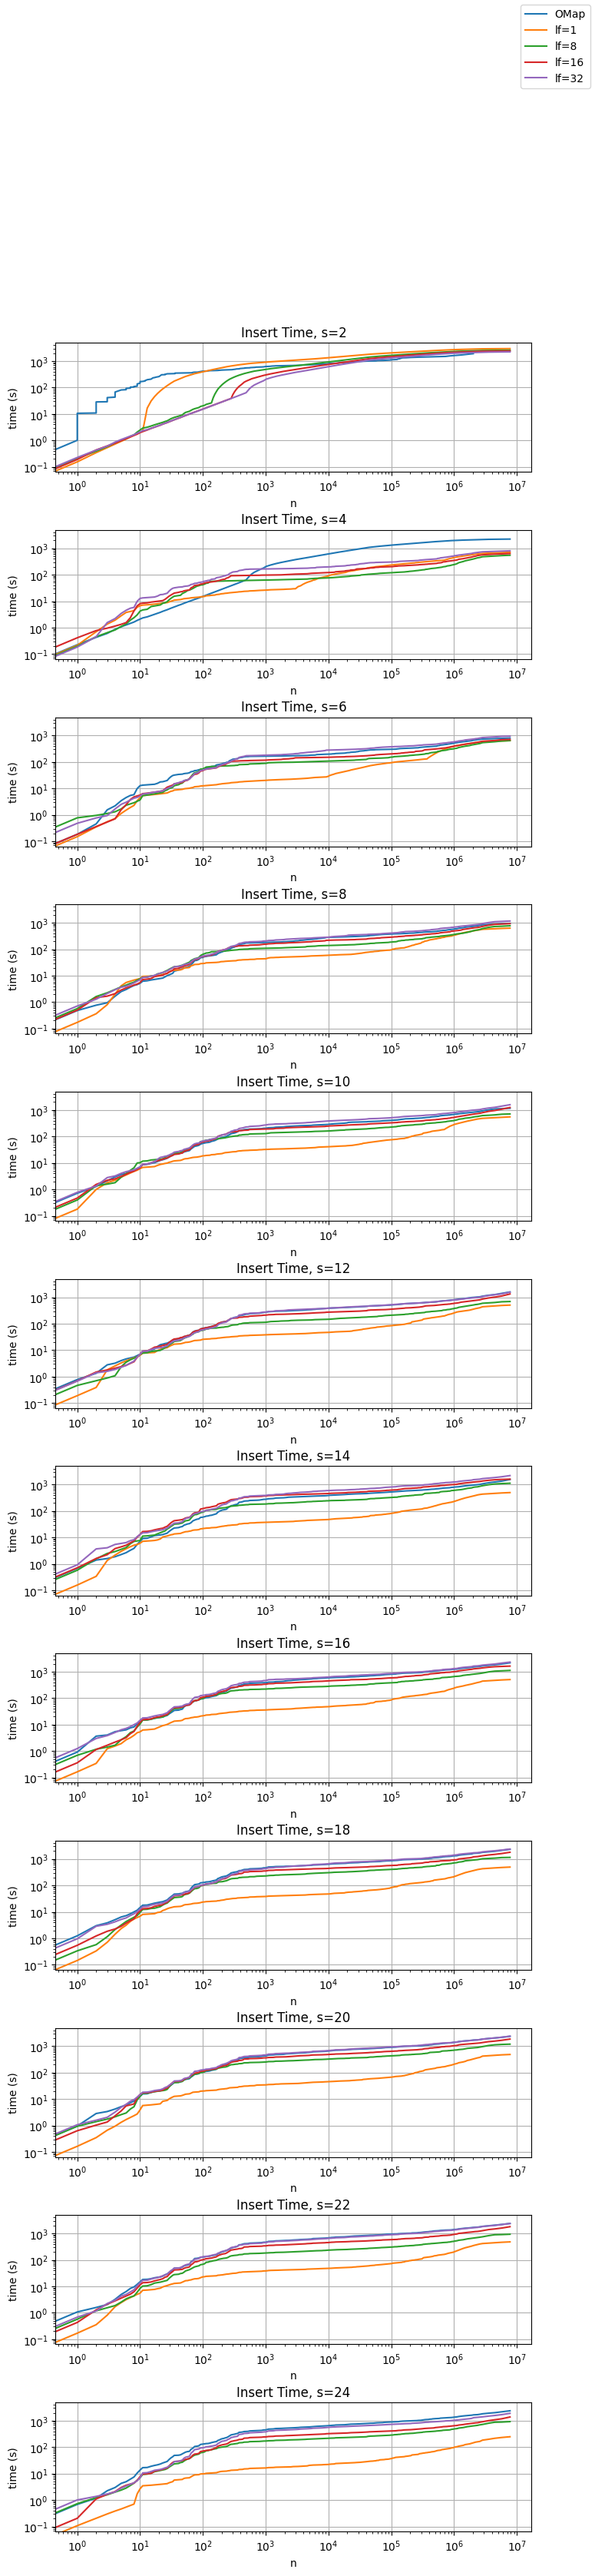

In [72]:
nplots = len(s_list)

yscale='log'
xscale='log'

fig, axs = plt.subplots(nplots, sharex=False, sharey=True, figsize=(8, (3*nplots)+1))
plt.subplots_adjust(hspace=.45)

x = np.asarray([si[0] for si in size_id_pairs])
omapx = x.cumsum()
omap_ins_time = list(set(filterr(ssd_omap, 'n', 2**23)['insert']))[0]
omapy = (x * omap_ins_time).cumsum()

for cnt, s in enumerate(s_list):
  ax = axs[cnt]
  ax.grid()
  setup_plot(f'Insert Time, {s=}', 'n', 'time (s)', ax=ax, xscale=xscale, yscale=yscale)

  plot_line(x, y, 'OMap', ax=ax)

  s_d = filterr(ssd_ofs, 's', s)
  s_lf_list = sorted(list(set(s_d['lf'])))
  for lf in s_lf_list:
    d = filterr(s_d, 'lf', lf)
    d.sort_values(['vl', 'id'], ascending=[True, True], inplace=True)
    x = d['vl'].cumsum()
    y = d['insert'].cumsum()
    plot_line(x, y, f'{lf=}', ax=ax)


labels_handles = {
  label: handle
    for ax in axs
    for handle, label in zip(*ax.get_legend_handles_labels())
}
fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc = "upper right",
#   bbox_to_anchor = (0.5, 0),
  bbox_transform = plt.gcf().transFigure,
)

plt.show()

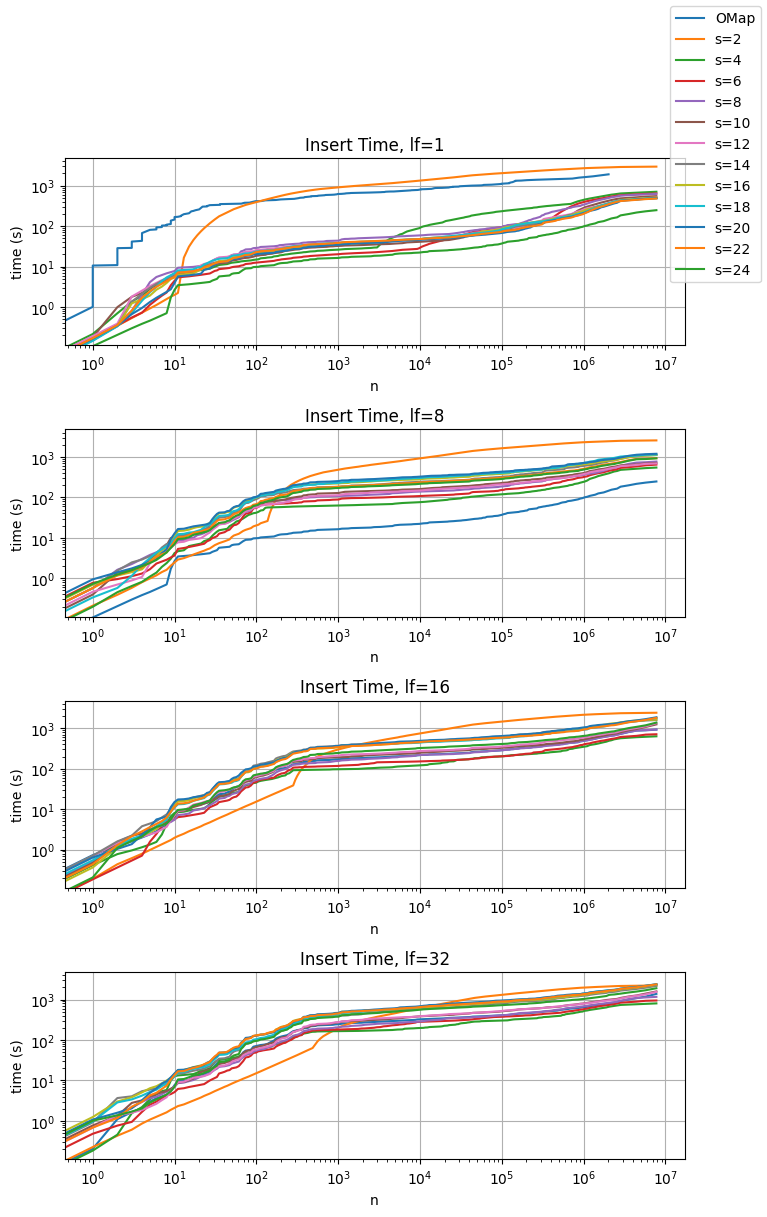

In [71]:
nplots = len(lf_list)

yscale='log'
xscale='log'

fig, axs = plt.subplots(nplots, sharex=False, sharey=True, figsize=(8, (3*nplots)+1))
plt.subplots_adjust(hspace=.45)

x = np.asarray([si[0] for si in size_id_pairs])
omapx = x.cumsum()
omap_ins_time = list(set(filterr(ssd_omap, 'n', 2**23)['insert']))[0]
omapy = (x * omap_ins_time).cumsum()

for cnt, lf in enumerate(lf_list):
  ax = axs[cnt]
  ax.grid()
  setup_plot(f'Insert Time, {lf=}', 'n', 'time (s)', ax=ax, xscale=xscale, yscale=yscale)

  plot_line(x, y, 'OMap', ax=ax)
  lf_d = filterr(ssd_ofs, 'lf', lf)
  lf_s_list = sorted(list(set(lf_d['s'])))
  for s in lf_s_list:
    d = filterr(lf_d, 's', s)
    d.sort_values(['vl', 'id'], ascending=[True, True], inplace=True)
    x = d['vl'].cumsum()
    y = d['insert'].cumsum()
    plot_line(x, y, f'{s=}', ax=ax)


labels_handles = {
  label: handle
    for ax in axs
    for handle, label in zip(*ax.get_legend_handles_labels())
}
fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc = "upper right",
#   bbox_to_anchor = (0.5, 0),
  bbox_transform = plt.gcf().transFigure,
)

plt.show()

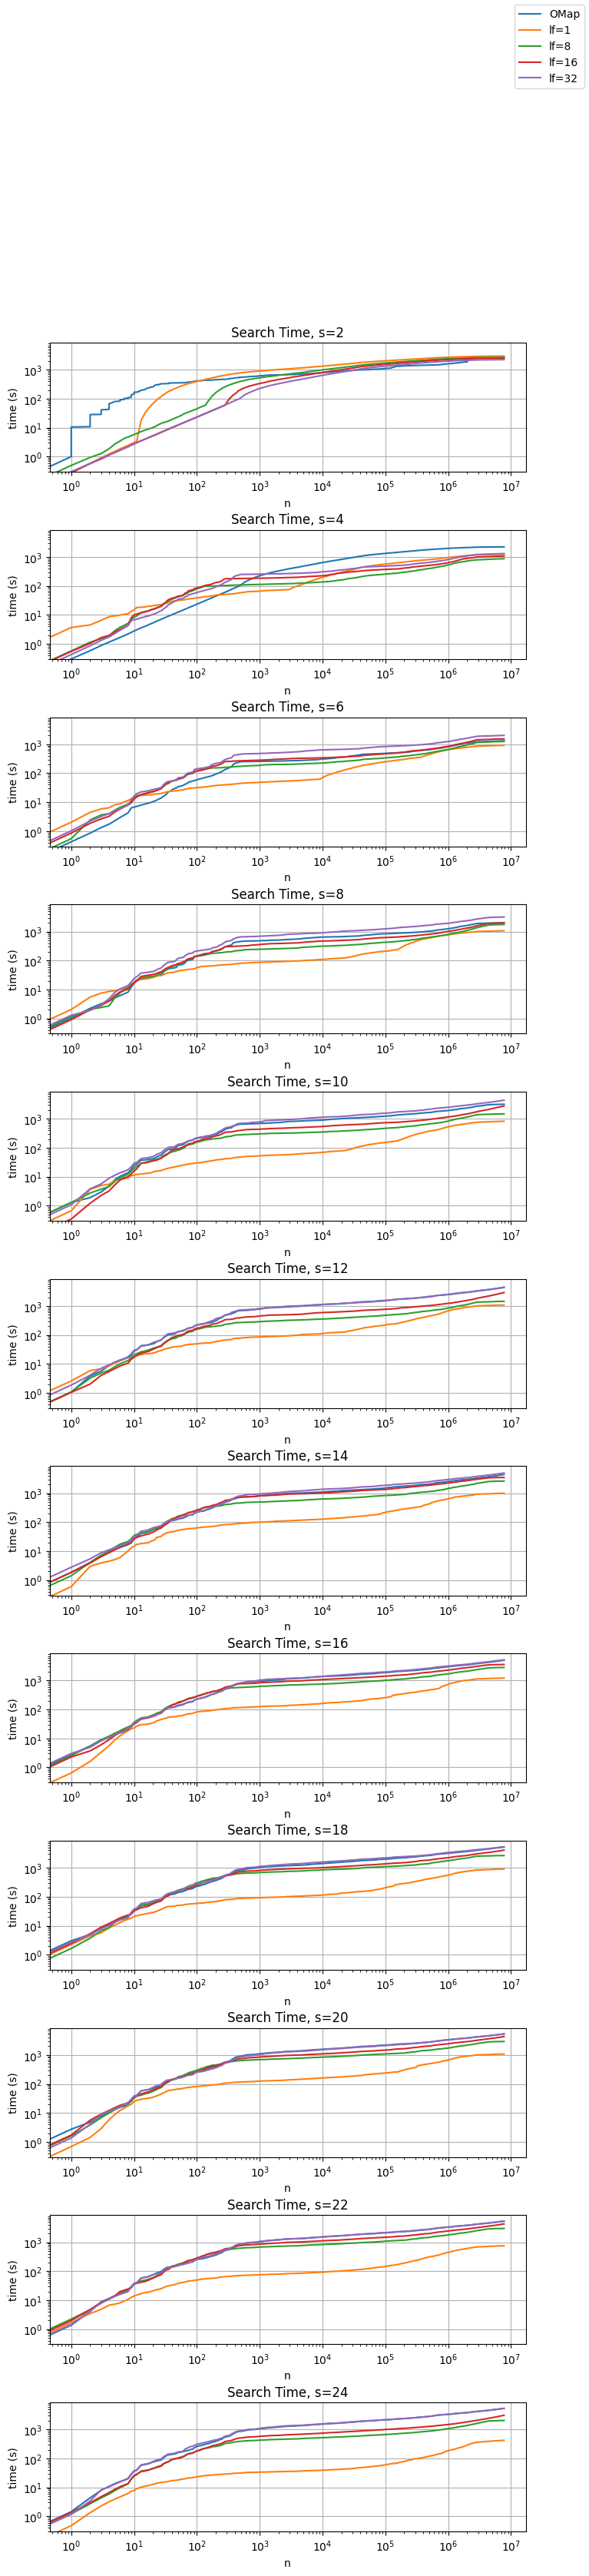

In [73]:
nplots = len(s_list)

yscale='log'
xscale='log'

fig, axs = plt.subplots(nplots, sharex=False, sharey=True, figsize=(8, (3*nplots)+1))
plt.subplots_adjust(hspace=.45)

x = np.asarray([si[0] for si in size_id_pairs])
omapx = x.cumsum()
omap_ins_time = list(set(filterr(ssd_omap, 'n', 2**23)['search']))[0]
omapy = (x * omap_ins_time).cumsum()

for cnt, s in enumerate(s_list):
  ax = axs[cnt]
  ax.grid()
  setup_plot(f'Search Time, {s=}', 'n', 'time (s)', ax=ax, xscale=xscale, yscale=yscale)

  plot_line(x, y, 'OMap', ax=ax)

  s_d = filterr(ssd_ofs, 's', s)
  s_lf_list = sorted(list(set(s_d['lf'])))
  for lf in s_lf_list:
    d = filterr(s_d, 'lf', lf)
    d.sort_values(['vl', 'id'], ascending=[True, True], inplace=True)
    x = d['vl'].cumsum()
    y = d['search'].cumsum()
    plot_line(x, y, f'{lf=}', ax=ax)


labels_handles = {
  label: handle
    for ax in axs
    for handle, label in zip(*ax.get_legend_handles_labels())
}
fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc = "upper right",
#   bbox_to_anchor = (0.5, 0),
  bbox_transform = plt.gcf().transFigure,
)

plt.show()

In [ ]:
nplots = len(lf_list)

yscale='log'
xscale='log'

fig, axs = plt.subplots(nplots, sharex=False, sharey=True, figsize=(8, (3*nplots)+1))
plt.subplots_adjust(hspace=.45)

x = np.asarray([si[0] for si in size_id_pairs])
omapx = x.cumsum()
omap_ins_time = list(set(filterr(ssd_omap, 'n', 2**23)['insert']))[0]
omapy = (x * omap_ins_time).cumsum()

for cnt, lf in enumerate(lf_list):
  ax = axs[cnt]
  ax.grid()
  setup_plot(f'Insert Time, {lf=}', 'n', 'time (s)', ax=ax, xscale=xscale, yscale=yscale)

  plot_line(x, y, 'OMap', ax=ax)
  lf_d = filterr(ssd_ofs, 'lf', lf)
  lf_s_list = sorted(list(set(lf_d['s'])))
  for s in lf_s_list:
    d = filterr(lf_d, 's', s)
    d.sort_values(['vl', 'id'], ascending=[True, True], inplace=True)
    x = d['vl'].cumsum()
    y = d['insert'].cumsum()
    plot_line(x, y, f'{s=}', ax=ax)


labels_handles = {
  label: handle
    for ax in axs
    for handle, label in zip(*ax.get_legend_handles_labels())
}
fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc = "upper right",
#   bbox_to_anchor = (0.5, 0),
  bbox_transform = plt.gcf().transFigure,
)

plt.show()